In [1]:
_=!git clone https://github.com/Sht97/Accelerometer-Gyro-dataset.git dataset
!cd dataset && git pull

Already up to date.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import tensorflow as tf
from scikitplot.metrics import plot_confusion_matrix#Esta librería toca instalarla "conda install -c conda-forge scikit-plot"
from sklearn.model_selection import train_test_split

In [33]:
def get_conv_model_A(num_classes,num_filtros,size_filtros, compile=True):
    
    #print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(300,6), name="input_1")
    layers = tf.keras.layers.Conv1D(num_filtros,size_filtros, activation="relu", padding="SAME")(inputs)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    if compile:
        model.compile(optimizer=opt,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model


def train(model,x_train,y_train,x_test, y_test, batch_size, epochs, model_name=""):
    model.reset_states()
    h = model.fit(x_train, y_train, epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_test, y_test),verbose=0)
    #metrics = model.evaluate(x_test, y_test)
    return h #{k:v for k,v in zip (model.metrics_names, metrics)}

In [ ]:
#aqui estan los metodos que crean ell modelo y lo entrenan, aqui se puede ver el arquitectura del modelo (get_conv_model_A)

In [34]:
archivos  = ['Daniel/Activacion','Daniel/Complejo','Daniel/Encender','Daniel/X'
             ,'Raul/Activacion','Raul/Complejo','Raul/Encender','Raul/X']
archivos2 = ['Daniel/Encender','Raul/Encender','Daniel/Complejo','Raul/Complejo','Daniel/X','Raul/X']

 
G0 = ['Daniel/Activacion','Raul/Activacion']  # 0
G1 = ['Daniel/Encender','Raul/Encender']    # 1 
G2 = ['Daniel/Complejo','Raul/Complejo']    # 2
G3 = ['Daniel/X','Raul/X']           # 3

x = []
y = []
for archivo in archivos:
    df1=pd.read_csv('dataset/'+ archivo +'.csv')

    cambios=df1[df1['Tiempo']=='Order'].index.tolist()

    for i in cambios:
        gesto1=df1[(df1.index>=i-300)&(df1.index<i)].astype(int)
        gesto1 = gesto1.to_numpy()

        m=np.fft.rfft(gesto1[:,2:8],axis=0)
        f=30
        ones=np.ones(f)
        zeros=np.zeros(m.shape[0]-f)
        c=np.concatenate((ones,zeros))
        clean=m*c.reshape(m.shape[0],1)
        m=np.fft.irfft(clean,axis=0)
        x.append(m)

#         x.append(gesto1[:,2:8])

        if archivo in G0:
            y.append(0)
        elif archivo in G1:
            y.append(1)
        elif archivo in G2:
            y.append(2)
        else:
            y.append(3)



x = np.array(x)
y = np.array(y)

x = (x+32762)/65536

x_train1,x_test1,y_train1,y_test1 =  train_test_split(x,y)
x_train2,x_test2,y_train2,y_test2 =  train_test_split(x,y)
x_train3,x_test3,y_train3,y_test3 =  train_test_split(x,y)
x_train4,x_test4,y_train4,y_test4 =  train_test_split(x,y)
x_train5,x_test5,y_train5,y_test5 =  train_test_split(x,y)

x_train = np.array([x_train1,x_train2,x_train3,x_train4,x_train5])
x_test = np.array([x_test1,x_test2,x_test3,x_test4,x_test5])
y_train = np.array([y_train1,y_train2,y_train3,y_train4,y_train5])
y_test = np.array([y_test1,y_test2,y_test3,y_test4,y_test5])



print(x_train.shape)
print(x_test.shape)

(5, 1219, 300, 6)
(5, 407, 300, 6)


3


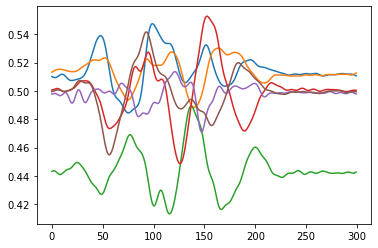

In [35]:
i = 650

plt.plot(x_train[0,i])
print(y_train[0,i])
plt.show()

In [27]:
model = get_conv_model_A(4,5,30)
copia = model.get_weights()[0].copy()
a = train(model,x_train[0],y_train[0],x_test[0],y_test[0], batch_size=100, epochs=100)
model.save('./modelos/prueva2.h5')

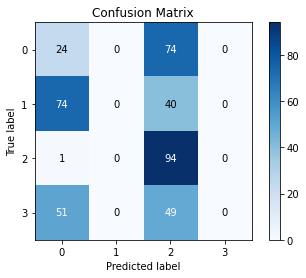

In [29]:
test_preds = model.predict(x_test[0]).argmax(axis=1)
plot_confusion_matrix(y_test[0], test_preds, normalize=False)

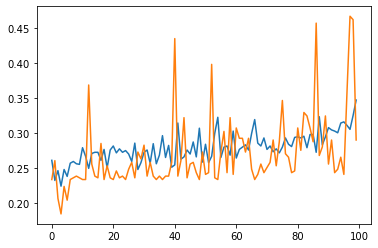

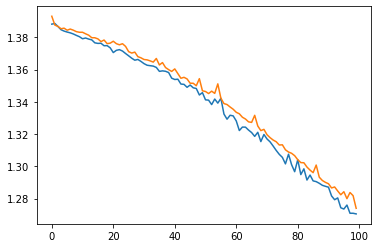

In [30]:
plt.plot(a.history['accuracy'])
plt.plot(a.history['val_accuracy'])
plt.show()
plt.plot(a.history['loss'])
plt.plot(a.history['val_loss'])
plt.show()

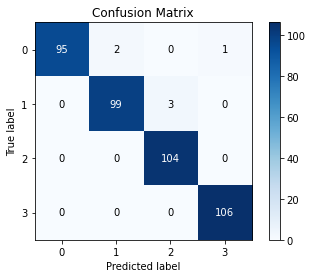

In [100]:
hola = tf.keras.models.load_model('./modelos/prueva.h5')
test_preds = hola.predict(x_test).argmax(axis=1)
plot_confusion_matrix(y_test, test_preds, normalize=False)

In [36]:
datos = {'batch_size': [],
        'sizeFilter': [],
        'numFilter': [],
        'LssTrain': [],
        'AccTrain': [],
        'LssVal': [],
        'AccVal': []
        }

datos = pd.DataFrame(datos, columns = ['batch_size','sizeFilter','numFilter','#','LssTrain','AccTrain','LssVal','AccVal'])

for i in [10,100]:
    print(i,' batch size')
    for j in [10,50,100]:
        print(j,' sizefilter')
        for k in [5,10,20,30]:
            print(k,' numFilter')
            model = get_conv_model_A(4,k,j)
            a = train(model,x_train[0],y_train[0],x_test[0],y_test[0], batch_size=i, epochs=1000, model_name="model_A")
            model.save('./modelos/modelo_bs'+str(i)+'_sf'+str(j)+'_nf'+str(k)+'.h5')


            fila = {'batch_size': [i],
                    'sizeFilter': [j],
                    'numFilter': [k],
                    'LssTrain': [a.history['loss']],
                    'AccTrain': [a.history['accuracy']],
                    'LssVal': [a.history['val_loss']],
                    'AccVal': [a.history['val_accuracy']]
                    }

            
            fila = pd.DataFrame(fila, columns = ['batch_size','sizeFilter','numFilter','LssTrain','AccTrain','LssVal','AccVal'])
            datos = datos.append(fila,ignore_index=True)
datos.to_csv(index=False)                

10  batch size
10  sizefilter
5  numFilter
10  numFilter
20  numFilter
30  numFilter
50  sizefilter
5  numFilter
10  numFilter
20  numFilter
30  numFilter
100  sizefilter
5  numFilter
10  numFilter
20  numFilter
30  numFilter
100  batch size
10  sizefilter
5  numFilter
10  numFilter
20  numFilter
30  numFilter
50  sizefilter
5  numFilter
10  numFilter
20  numFilter
30  numFilter
100  sizefilter
5  numFilter
10  numFilter
20  numFilter
30  numFilter


'batch_size,sizeFilter,numFilter,#,LssTrain,AccTrain,LssVal,AccVal\r\n10.0,10.0,5.0,,"[1.4213320016860962, 1.390514612197876, 1.3877694606781006, 1.3862251043319702, 1.3855689764022827, 1.3862354755401611, 1.3862093687057495, 1.3862000703811646, 1.386183261871338, 1.386176347732544, 1.386161208152771, 1.3861336708068848, 1.386123776435852, 1.3861136436462402, 1.3861148357391357, 1.386089563369751, 1.3860803842544556, 1.3860678672790527, 1.386060118675232, 1.3860465288162231, 1.3860394954681396, 1.386033535003662, 1.386033296585083, 1.3860242366790771, 1.3860121965408325, 1.3859997987747192, 1.385998249053955, 1.3859894275665283, 1.3859878778457642, 1.385976791381836, 1.3859697580337524, 1.3859750032424927, 1.3859623670578003, 1.385958194732666, 1.3859484195709229, 1.3859531879425049, 1.385946273803711, 1.3859426975250244, 1.385936975479126, 1.3859272003173828, 1.3859366178512573, 1.3859333992004395, 1.3859164714813232, 1.3859158754348755, 1.385913610458374, 1.3859093189239502, 1.385909

In [ ]:
#con este codigo se hacce prueba de 24 modelos hacienndo cambios en su batch size sizefilter y el numero de filtros

In [37]:
datos
#estos datos son los hoostoriales de enntrennamiento de los modelos

,batch_size,sizeFilter,numFilter,#,LssTrain,AccTrain,LssVal,AccVal
0,10.0,10.0,5.0,NaN,"[1.4213320016860962, 1.390514612197876, 1.3877...","[0.24282199144363403, 0.254306823015213, 0.259...","[1.3990741968154907, 1.3897517919540405, 1.390...","[0.22604422271251678, 0.2923832833766937, 0.22..."
1,10.0,10.0,10.0,NaN,"[1.385286808013916, 1.3663386106491089, 1.3524...","[0.2731747329235077, 0.30352747440338135, 0.36...","[1.3699177503585815, 1.3523186445236206, 1.335...","[0.2309582382440567, 0.25307124853134155, 0.49..."
2,10.0,10.0,20.0,NaN,"[1.3907592296600342, 1.3862789869308472, 1.386...","[0.2510254383087158, 0.2616899013519287, 0.261...","[1.3863862752914429, 1.3864290714263916, 1.386...","[0.22604422271251678, 0.22604422271251678, 0.2..."
3,10.0,10.0,30.0,NaN,"[1.3896962404251099, 1.3862797021865845, 1.386...","[0.24774405360221863, 0.2616899013519287, 0.26...","[1.386344313621521, 1.386400818824768, 1.38645...","[0.22604422271251678, 0.22604422271251678, 0.2..."
4,10.0,50.0,5.0,NaN,"[1.387946605682373, 1.387749195098877, 1.38364...","[0.2657916247844696, 0.24610336124897003, 0.27...","[1.3878660202026367, 1.389830231666565, 1.3840...","[0.2383292317390442, 0.24570024013519287, 0.17..."
5,10.0,50.0,10.0,NaN,"[1.3900600671768188, 1.386284589767456, 1.3862...","[0.2502050995826721, 0.24692371487617493, 0.24...","[1.3863484859466553, 1.3864154815673828, 1.386...","[0.24078623950481415, 0.22604422271251678, 0.2..."
6,10.0,50.0,20.0,NaN,"[1.3900500535964966, 1.3863121271133423, 1.386...","[0.23789991438388824, 0.23543888330459595, 0.2...","[1.3863160610198975, 1.3863475322723389, 1.386...","[0.2383292317390442, 0.22604422271251678, 0.22..."
7,10.0,50.0,30.0,NaN,"[1.3944145441055298, 1.3863004446029663, 1.386...","[0.23379819095134735, 0.2518457770347595, 0.25...","[1.386300802230835, 1.3863521814346313, 1.3864...","[0.2383292317390442, 0.2383292317390442, 0.226..."
8,10.0,100.0,5.0,NaN,"[1.3841817378997803, 1.3735769987106323, 1.357...","[0.2649712860584259, 0.36259227991104126, 0.42...","[1.3785053491592407, 1.364387035369873, 1.3511...","[0.30958232283592224, 0.5405405163764954, 0.59..."
9,10.0,100.0,10.0,NaN,"[1.3903175592422485, 1.3872019052505493, 1.386...","[0.254306823015213, 0.24856439232826233, 0.261...","[1.3982981443405151, 1.3863049745559692, 1.386...","[0.22604422271251678, 0.22604422271251678, 0.2..."


0


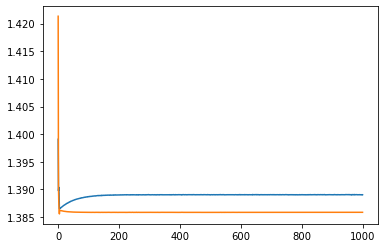

1


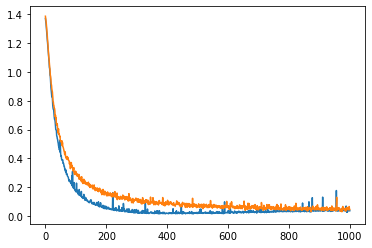

2


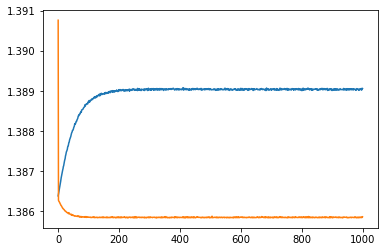

3


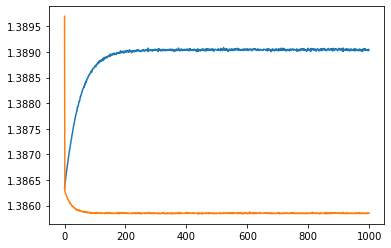

4


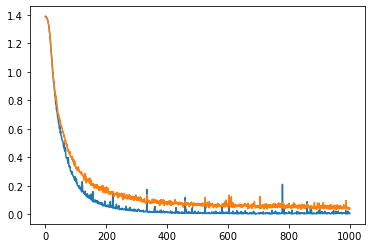

5


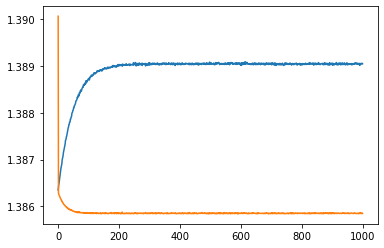

6


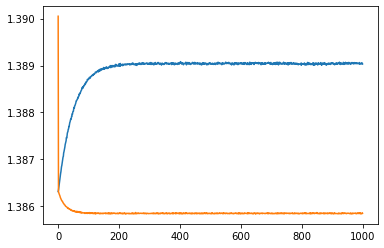

7


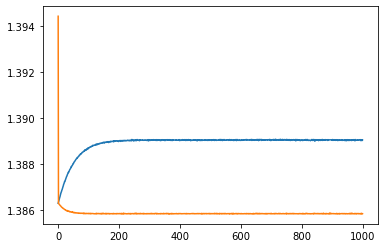

8


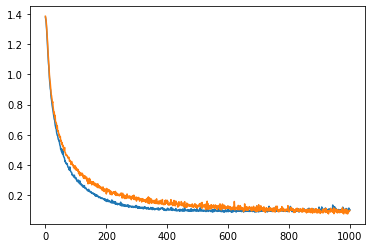

9


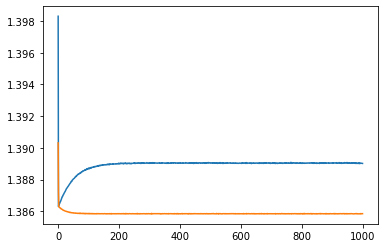

10


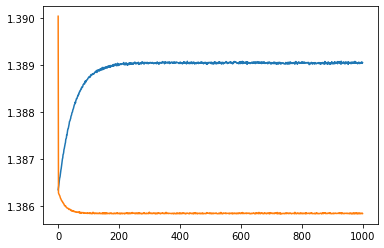

11


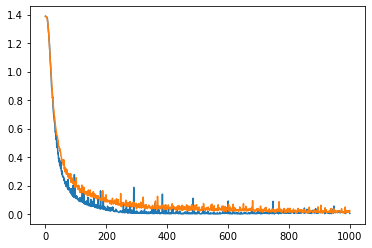

12


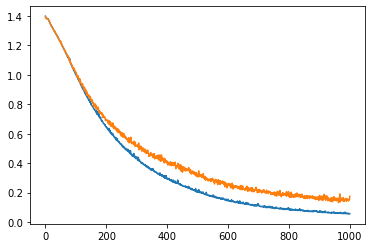

13


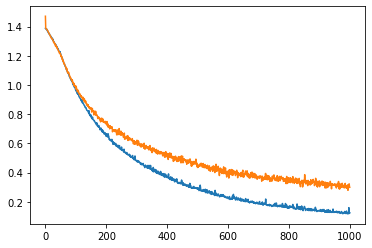

14


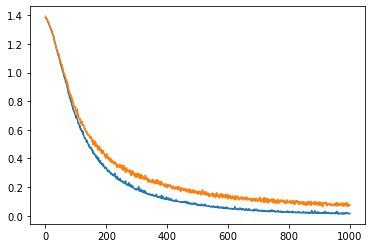

15


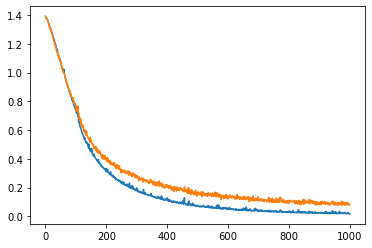

16


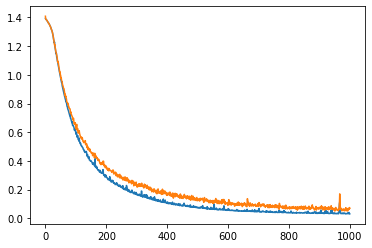

17


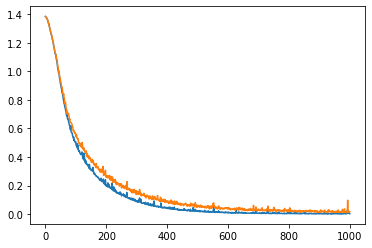

18


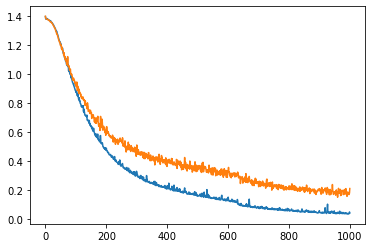

19


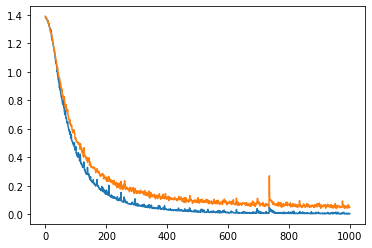

20


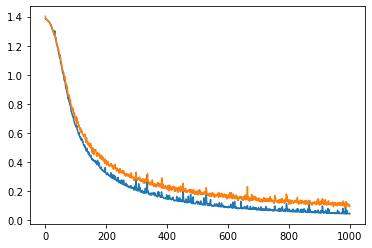

21


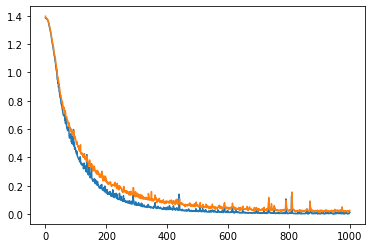

22


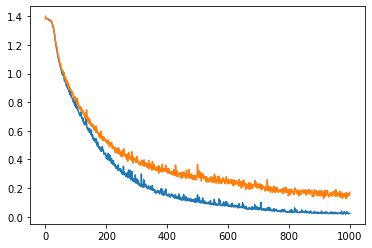

23


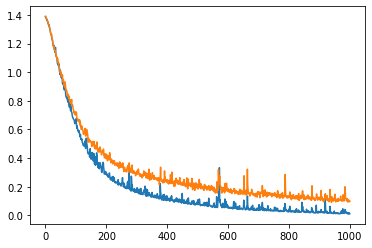

In [59]:
for i in range(24):
    curba1 = datos[datos.index == i]['LssVal'].tolist()
    curba2 = datos[datos.index == i]['LssTrain'].tolist()
    print(i)
    plt.plot(curba1[0])
    plt.plot(curba2[0])
    plt.show()

0


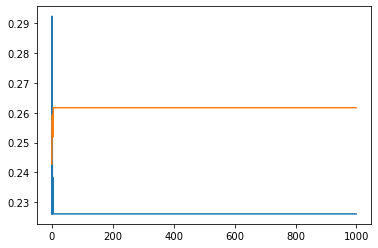

1


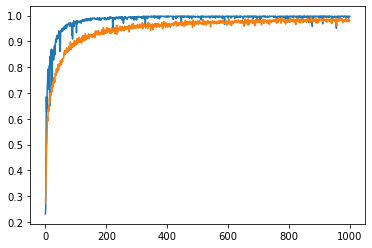

2


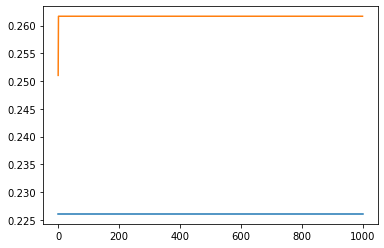

3


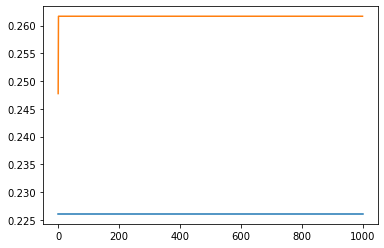

4


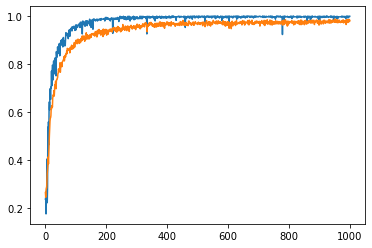

5


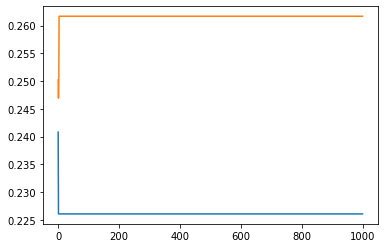

6


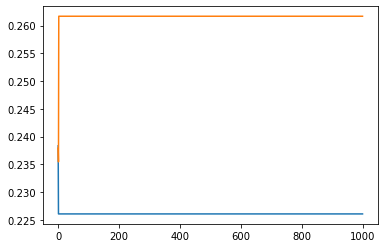

7


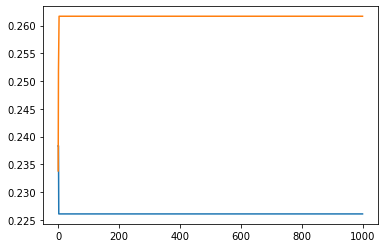

8


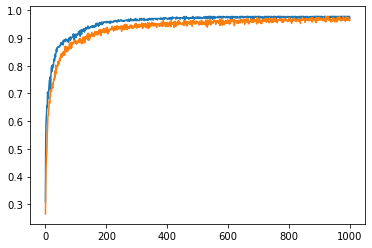

9


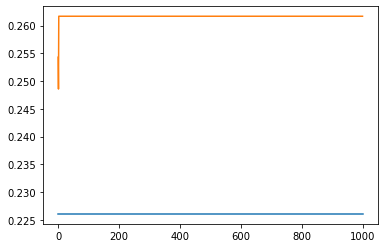

10


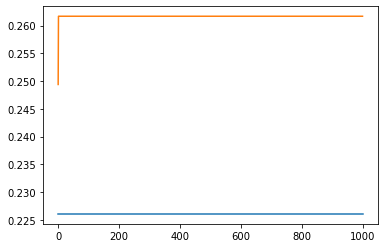

11


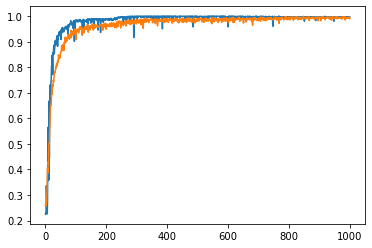

12


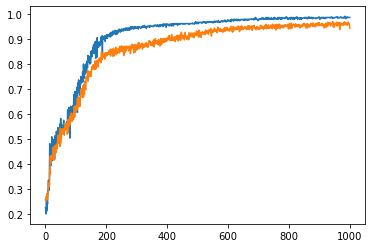

13


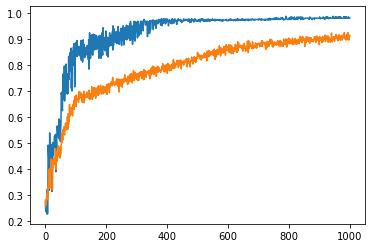

14


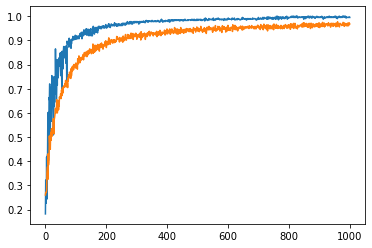

15


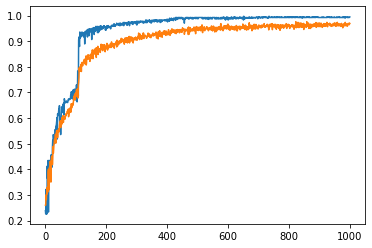

16


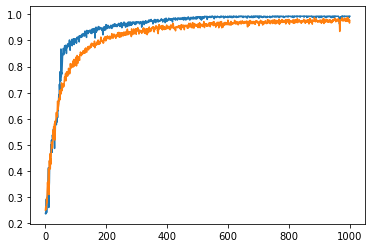

17


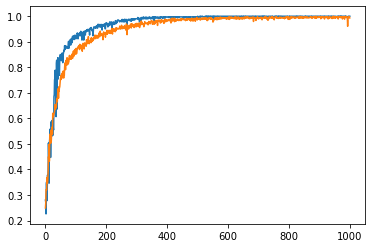

18


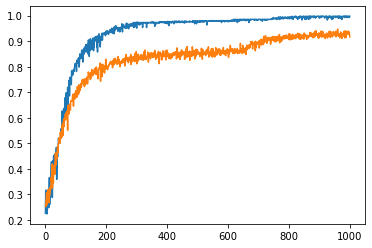

19


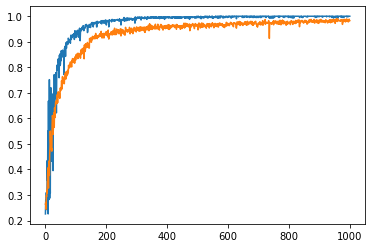

20


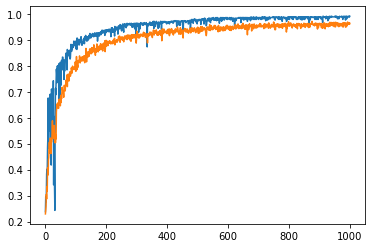

21


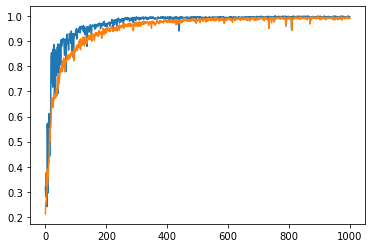

22


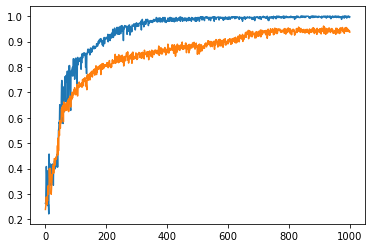

23


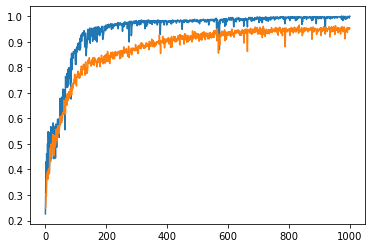

In [60]:
for i in range(24):
    curba1 = datos[datos.index == i]['AccVal'].tolist()
    curba2 = datos[datos.index == i]['AccTrain'].tolist()
    print(i)
    plt.plot(curba1[0])
    plt.plot(curba2[0])
    plt.show()

In [62]:
datos.to_csv('nombre.csv')

In [4]:

df1=pd.read_csv('Muestras/PruebaAgena.csv')

cambios=df1[df1['Tiempo']=='Order'].index.tolist()

contador = 0
x= []
y=[]
for i in cambios:
    gesto1=df1[(df1.index>=i-300)&(df1.index<i)].astype(int)
    gesto1 = gesto1.to_numpy()

    m=np.fft.rfft(gesto1[:,2:8],axis=0)
    f=30
    ones=np.ones(f)
    zeros=np.zeros(m.shape[0]-f)
    c=np.concatenate((ones,zeros))
    clean=m*c.reshape(m.shape[0],1)
    m=np.fft.irfft(clean,axis=0)
    x.append(m)

#   x.append(gesto1[:,2:8])

y=[1,1,1,1,1,3,3,3,3,3,2,2,2,2,2,0,0,0,0,0,1,1,1,1,1,3,3,3,3,3,2,2,2,2,2,0,0,0,0,0,1,1,1,1,1,3,3,3,3,3,2,2,2,2,2,0,0,0,0,0]
x = np.array(x)
y = np.array(y)
x = (x+32762)/65536
print(x.shape)

(60, 300, 6)


In [ ]:
#se crea un dataset de muuestras que no estaban dentro del conjunto de enntrenamiento para probar los mejores modelos3.
# dado que todos los modelos fueron guardados solo es importarllo y hacer la prueba con ell dataset
# aqui sollo se prueban llos que tubieron buenas curvas de aprendisaje 

Model: "functional_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 6)]          0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 300, 5)            3005      
_________________________________________________________________
flatten_22 (Flatten)         (None, 1500)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)                24016     
_________________________________________________________________
dropout_22 (Dropout)         (None, 16)                0         
_________________________________________________________________
output_1 (Dense)             (None, 4)                 68        
Total params: 27,089
Trainable params: 27,089
Non-trainable params: 0
_________________________________________________

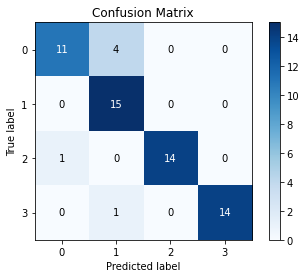

In [7]:
model =  tf.keras.models.load_model('./modelos/modelo_bs100_sf100_nf5.h5')
test_preds = model.predict(x).argmax(axis=1)
plot_confusion_matrix(y, test_preds, normalize=False)
model.summary()

Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 6)]          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 300, 30)           18030     
_________________________________________________________________
flatten_13 (Flatten)         (None, 9000)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                144016    
_________________________________________________________________
dropout_13 (Dropout)         (None, 16)                0         
_________________________________________________________________
output_1 (Dense)             (None, 4)                 68        
Total params: 162,114
Trainable params: 162,114
Non-trainable params: 0
_______________________________________________

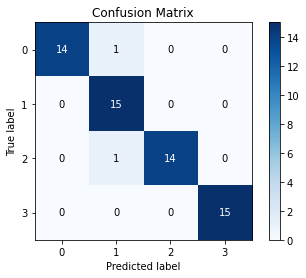

In [13]:
del model
model =  tf.keras.models.load_model('./modelos/modelo_bs10_sf100_nf30.h5')
test_preds = model.predict(x).argmax(axis=1)
plot_confusion_matrix(y, test_preds, normalize=False)
model.summary()

In [14]:
model =  tf.keras.models.load_model('./modelos/modelo_bs100_sf10_nf5.h5')
test_preds = model.predict(x).argmax(axis=1)
test_preds

array([1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 1, 1, 1, 1,
       1, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1], dtype=int64)